## ARIMA モデルで予測してみる
https://www.kaggle.com/code/ranja7/predict-future-sales-arima-forecasts　

### SET UP

In [1]:
%%time
# ライブラリのインポート
import pandas as pd

# パス指定
filepath_train = "./data/sales_train.csv"
filepath_test = "./data/test.csv"

# データのインポート
df_train = pd.read_csv(filepath_or_buffer = filepath_train)
df_test = pd.read_csv(filepath_or_buffer = filepath_test)

# データサイズの確認
df_train.shape, df_test.shape

CPU times: user 672 ms, sys: 124 ms, total: 795 ms
Wall time: 890 ms


((2935849, 6), (214200, 3))

In [2]:
# 訓練データから０より小さい価格のrowを抜く。
#　１行だけ存在しており、おそらく値引きか返品
df_train = df_train[df_train['item_price'] > 0]

# date列を型変換[object　--> datetime]
from datetime import datetime
df_train["date"] = df_train['date'].apply(lambda x:datetime.strptime(x, '%d.%m.%Y'))

### Data processing

アイテムの毎月の売り上げを計算するため、日毎に売り上げを合計する

In [3]:
# date列から年月を抽出
df_train['month'] = df_train['date'].dt.to_period('M')
# month列の型変換[period[M] --> str]
df_train['month'] = df_train['month'].astype(str)
# month列の型変換[str --> datetime64]
df_train['month'] = pd.to_datetime(df_train['month'])

# 訓練データの情報を再確認
df_train.dtypes
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,2013-01-02,0,59,22154,999.00,1.0,2013-01-01
1,2013-01-03,0,25,2552,899.00,1.0,2013-01-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013-01-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013-01-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01-01
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015-10-01
2935845,2015-10-09,33,25,7460,299.00,1.0,2015-10-01
2935846,2015-10-14,33,25,7459,349.00,1.0,2015-10-01
2935847,2015-10-22,33,25,7440,299.00,1.0,2015-10-01


In [4]:
# 年月別の商品合計数のデータフレームを新たに作成する

## 年月別の商品合計数のデータフレームを作成
dff_train = df_train.groupby(['month']).agg({'item_cnt_day' : 'sum'})
## 年月をindexからcolumnに移行
dff_train['month'] = dff_train.index
## 商品合計数のカラム名を変更し、上書き。
dff_train.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

## データの行数と型を確認
print(dff_train.shape[0])
print(dff_train.dtypes)

34
item_cnt_month           float64
month             datetime64[ns]
dtype: object


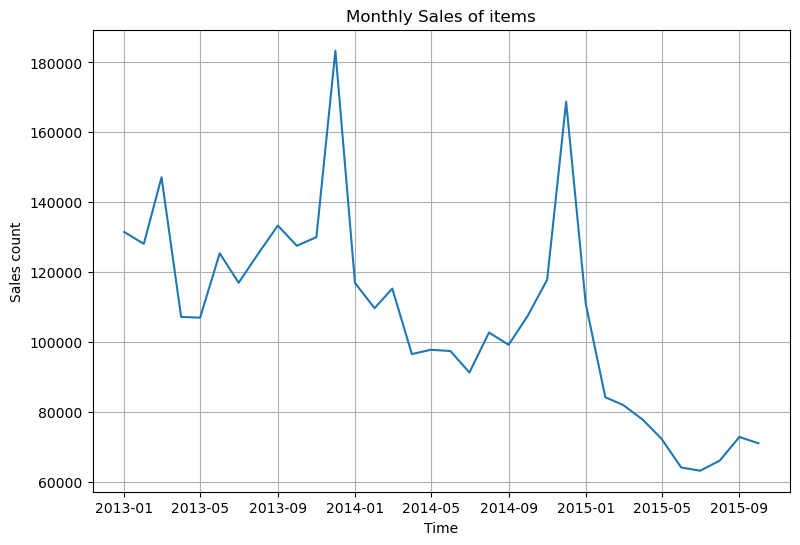

In [5]:
# データの可視化 --> df.年月別商品合計

import matplotlib.pyplot as plt

# 描画の各種設定
plt.figure(figsize = (9, 6))
plt.grid()
plt.title('Monthly Sales of items')
plt.xlabel('Time')
plt.ylabel('Sales count')
# 商品合計数の折れ線グラフ
plt.plot(dff_train['item_cnt_month'])

plt.show()



### EDA(Exploratory Data Analysis)

Autocorrelation = 0.6636


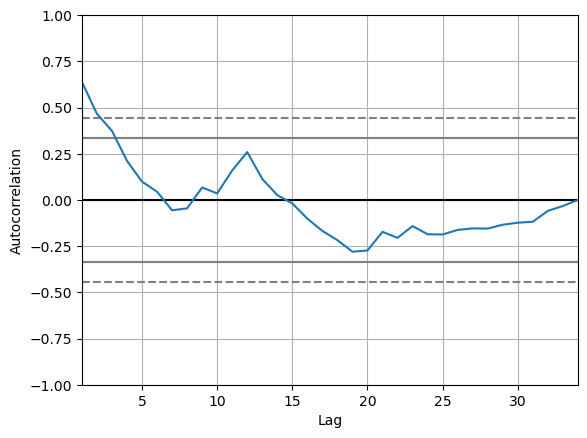

In [6]:
# 自己相関グラフの出力
pd.plotting.autocorrelation_plot(dff_train['item_cnt_month'])
# 自己相関係数の出力
print('Autocorrelation =', round(dff_train['item_cnt_month'].autocorr(), 4))

/Users/udai/miniforge3/envs/python39/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


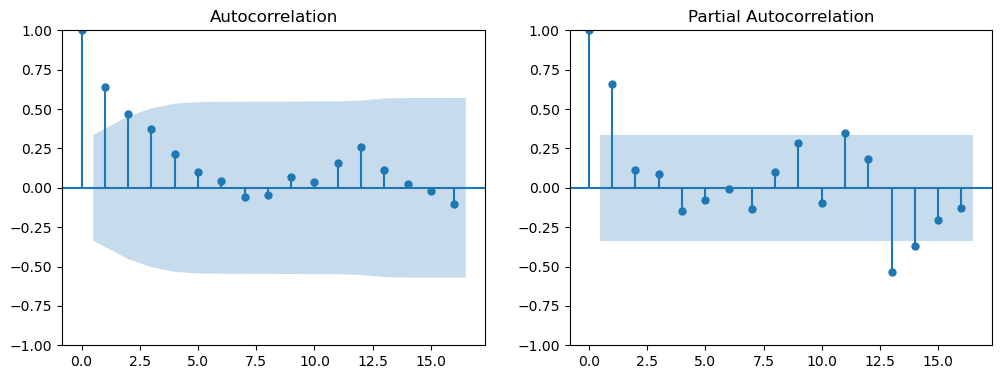

In [7]:
# コレログラムの表示

## 描画の各種設定
plt.figure(figsize = (12, 9))
ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 自己相関のコレログラムを出力
plot_acf(dff_train['item_cnt_month'], ax = ax1, alpha = 0.05)
plt.grid()
# 偏自己相関のコレログラムを出力
plot_pacf(dff_train['item_cnt_month'], ax = ax2, alpha = 0.05)
plt.grid()


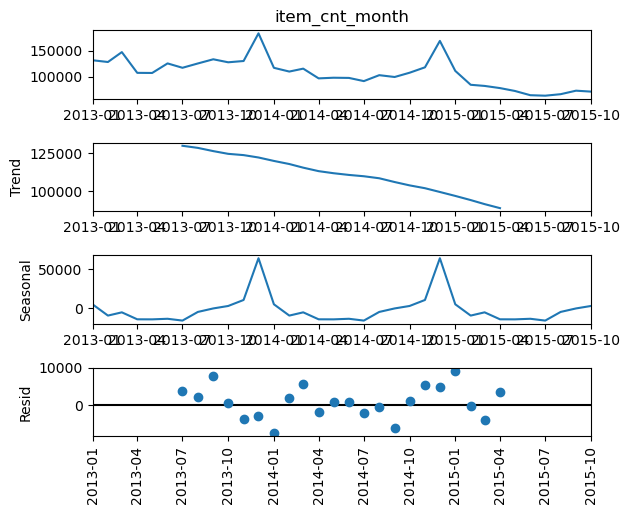

In [8]:
# 変動成分を分解する --> 移動平均（加法）

from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(dff_train['item_cnt_month'], model = 'additive').plot()
plt.xticks(rotation = 90)
plt.show()

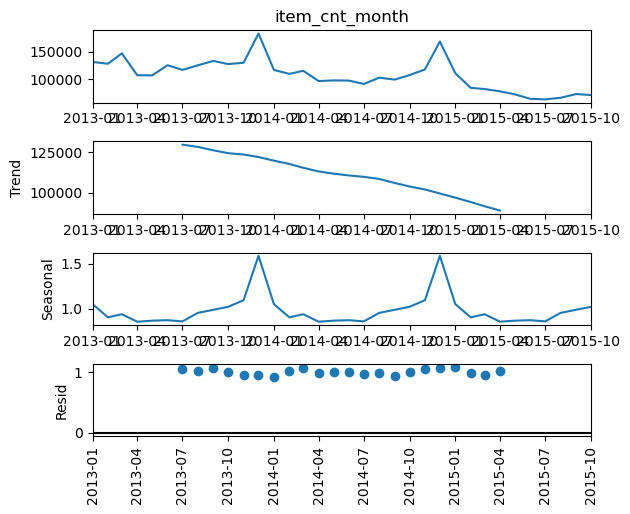

In [9]:
# 変動成分を分解する --> 移動平均（乗法）

seasonal_decompose(dff_train['item_cnt_month'], model = 'multiplicative').plot()
plt.xticks(rotation = 90)
plt.show()

### Time-series stationarity tests --> 時系列定常性検定

In [10]:
from statsmodels.tsa.stattools import adfuller
adfuller(dff_train['item_cnt_month'])

(-2.3957078654283426,
 0.1429514984190895,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 530.9537360897348)

In [11]:
# Stationarity test
from statsmodels.tsa.stattools import adfuller

# ADF検定を実装し、結果をSeries型で出力する関数
def adf_test(dataseries):

    # adfullerでADF検定を実施
    adf = adfuller(x = dataseries)
    # 結果の上位4つをSeriesに格納
    # 1.ADF統計量 / 2.p値 / 3.ラグ
    output = pd.Series(adf[0:3], index = ['ADF Statistic', 'p-value', 'Lags'])
    
    # 4.棄却限界値
    for key, value in adf[4].items():
        output['Critical Value (%s)' % key] = value

    return print(output)

adf_test(dff_train['item_cnt_month'])


ADF Statistic          -2.395708
p-value                 0.142951
Lags                    0.000000
Critical Value (1%)    -3.646135
Critical Value (5%)    -2.954127
Critical Value (10%)   -2.615968
dtype: float64


上記の結果から、非定常性をもつデータであることがわかる。

トレンド成分については、下降トレンド。季節成分については、12ヶ月周期が見られる。

### Model parameters search --> パラメータ探索

In [12]:
# Auto-ARIMAモデルの作成

from pmdarima.arima import auto_arima

def order_parameters(training_data):

    # 各種パラメータの設定をし、インスタンス化。
    search_params = auto_arima(y = training_data, # pd.Series or NumPyの1次元
                               start_p = 0, # 非季節性AR
                               d = None, # 非季節性階差
                               start_q = 0, # 非季節性MAR
                               m = 12, # 今回は12ヶ月周期
                               seasonal = True, # SARIMA
                               information_criterion = 'aic', # 情報量基準。尤度とパラメータで選定。
                               alpha = 0.05, # 有意水準
                               test = 'adf', # 定常性を検出する
                               stepwise = True, # アルゴリズム名。過学習対策。
                               trace = True, #デバッグ情報を出力する
                               suppress_warnings = True, # 警告文の抑制
                               )
    
    # AICの出力
    print('AIC = ', round(search_params.aic(), 2))

    # モデルを返す。
    return search_params

In [13]:
%%time
# モデルを呼び出す。
model = order_parameters(dff_train['item_cnt_month'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=448.765, Time=0.04 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=451.737, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=449.440, Time=0.02 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=438.096, Time=0.04 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=439.393, Time=0.06 sec
 ARIMA(0,2,1)(0,1,2)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=438.173, Time=0.04 sec
 ARIMA(0,2,1)(1,1,2)[12]             : AIC=440.703, Time=0.18 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=448.622, Time=0.02 sec
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=451.418, Time=0.04 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=449.123, Time=0.02 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[12] intercept   : AIC=inf, T

### Optimal SARIMA model --> 最適なSARIMAモデル

In [14]:
# モデル作成結果の表示
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -216.048
Date:                            Wed, 14 Dec 2022   AIC                            438.096
Time:                                    15:19:48   BIC                            441.083
Sample:                                01-01-2013   HQIC                           438.679
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9856      0.298     -3.311      0.001      -1.569      -0.402
ma.S.L12      -0.0853      0.168   

### Predictions

In [15]:
# 予測結果と予測の信頼区間(95%)を返す。
prediction, confint = model.predict(n_periods = 7, # 予測の期間を指定。dafault:10
                                    return_conf_int = True)

# 信頼区間をDataFrameに格納 
df_confint = pd.DataFrame(confint)
df_confint = df_confint[0:6]
df_confint

,0,1
0,49454.658385,106326.452618
1,84822.082737,166628.206108
2,14725.148888,116583.020036
3,-22076.640073,97439.170080
4,-34512.161157,101210.250764
5,-50585.046722,100365.233401


In [16]:
# 予測結果のデータフレームを作成
df_predict = pd.DataFrame({'Predicted item_cnt_month' : prediction[0:6].round(2)})

# 予測結果に色をつけて表示
df_predict.style.background_gradient(cmap = 'Reds')

,Predicted item_cnt_month
2015-11-01 00:00:00,77890.560000
2015-12-01 00:00:00,125725.140000
2016-01-01 00:00:00,65654.080000
2016-02-01 00:00:00,37681.270000
2016-03-01 00:00:00,33349.040000
2016-04-01 00:00:00,24890.090000


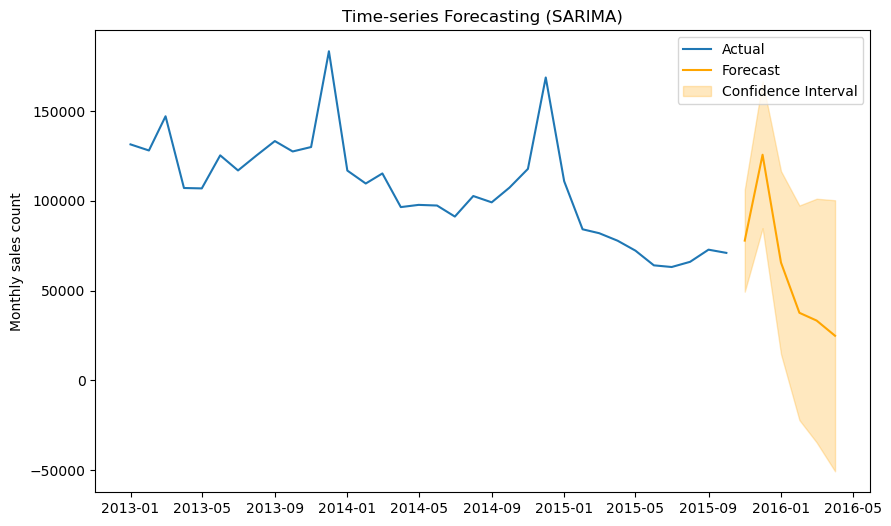

In [17]:
# 予測対象の期間をデータフレームとして格納
period_index = pd.period_range(start = dff_train.index[-1], periods = 7, freq = 'M')
period_index = period_index[1:7]

# 描画の設定
plt.figure(figsize = (10, 6))
# 既存データのプロット
plt.plot(dff_train['item_cnt_month'], label = 'Actual')
# 予測結果のプロット
plt.plot(df_predict, color = 'orange', label = 'Forecast')
# 予測結果の信頼区間の表示
plt.fill_between(period_index.to_timestamp(), df_confint[0], df_confint[1], color = 'orange', alpha = 0.25, label = 'Confidence Interval')

# 凡例の表示
plt.legend()
plt.title('Time-series Forecasting (SARIMA)')
plt.ylabel('Monthly sales count')
plt.show()

### Results

In [18]:
# 店舗とアイテムIDでグルーピング
# --> 日別に合計してまとめる
train_df_tuple = df_train.groupby(['shop_id', 'item_id']).sum()
train_df_tuple = train_df_tuple.reset_index()
train_df_tuple = train_df_tuple.drop(['date_block_num', 'item_price'], axis = 1)
train_df_tuple

/var/folders/6x/0whm9kbs4bg6p6xq6w7vsm0r0000gn/T/ipykernel_35367/413746669.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df_tuple = df_train.groupby(['shop_id', 'item_id']).sum()


,shop_id,item_id,item_cnt_day
0,0,30,31.0
1,0,31,11.0
2,0,32,16.0
3,0,33,6.0
4,0,35,15.0
...,...,...,...
424119,59,22154,1.0
424120,59,22155,1.0
424121,59,22162,16.0
424122,59,22164,6.0


### 重みづけをしてみる

In [19]:
# 2015/11の予測データ × テストデータの行数(214,200) / 店舗別アイテム別dfの行数(424,124) / テストデータの行数(214,200)
df_test['item_cnt_month'] = (prediction[0].round(2) * len(df_test) / len(train_df_tuple)) / len(df_test)

In [20]:
df_test

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.18365
1,1,5,5320,0.18365
2,2,5,5233,0.18365
3,3,5,5232,0.18365
4,4,5,5268,0.18365
...,...,...,...,...
214195,214195,45,18454,0.18365
214196,214196,45,16188,0.18365
214197,214197,45,15757,0.18365
214198,214198,45,19648,0.18365


In [21]:
# 2013年11月と2014年11月
df_train_11 = df_train.query('date_block_num == 10 | date_block_num == 22')
df_train_11

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
1027580,2013-11-06,10,43,4420,299.0,1.0,2013-11-01
1027581,2013-11-16,10,28,10033,199.0,1.0,2013-11-01
1027582,2013-11-14,10,28,10051,149.0,1.0,2013-11-01
1027583,2013-11-22,10,28,10051,149.0,1.0,2013-11-01
1027584,2013-11-30,10,28,10051,149.0,1.0,2013-11-01
...,...,...,...,...,...,...,...
2192632,2014-11-26,22,42,59,249.0,1.0,2014-11-01
2192633,2014-11-07,22,42,59,249.0,1.0,2014-11-01
2192634,2014-11-16,22,42,77,149.0,1.0,2014-11-01
2192635,2014-11-10,22,42,32,149.0,1.0,2014-11-01


In [22]:
# 重みの計算
from Feature_Engineering import F_Engineering

fe = F_Engineering(train = df_train_11, test = df_test)
df_test_w = fe.output_w()

In [24]:
import numpy as np

# テストデータの商品合計
item_cnt_total = np.sum(df_test_w.item_cnt_month)
item_cnt_total

# 重み×商品合計数　＝　重みを付加した[item_cnt_month]
# それを格納するための箱を用意
item_cnt_month_w = np.zeros(df_test_w.shape[0])

# 重み×商品合計数　＝　重みを付加した[item_cnt_month]
# 上記式を[shop_id]分実施
for i in range(df_test_w.shape[0]):
    item_cnt_month_w[i] = item_cnt_total * df_test_w["W"][i]

# 計算後の内容をデータフレームに格納
df_test_w['item_cnt_month_w'] = item_cnt_month_w
df_test_w

,ID,shop_id,item_id,item_cnt_month,W,item_cnt_month_w
0,0,5,5037,0.18365,0.000003,0.108156
1,1,5,5320,0.18365,0.000003,0.108156
2,2,5,5233,0.18365,0.000003,0.108156
3,3,5,5232,0.18365,0.000003,0.108156
4,4,5,5268,0.18365,0.000003,0.108156
...,...,...,...,...,...,...
214195,214195,45,18454,0.18365,0.000003,0.109720
214196,214196,45,16188,0.18365,0.000003,0.109720
214197,214197,45,15757,0.18365,0.000003,0.109720
214198,214198,45,19648,0.18365,0.000003,0.109720


In [25]:
# submissionの作成
## 不要なcolumnの削除
df_test_w = df_test_w.drop(["shop_id", "item_id", "item_cnt_month", "W"], axis = 1)
## rename
df_test_w.rename(columns = {"item_cnt_month_w" : "item_cnt_month"}, inplace = True)
## csv出力
df_test_w.to_csv('submission_2.csv', index = False)